# Toxic Comments Classification with DistilBERT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset desription:
The dataset contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat    
- insult
- identity_hate

File descriptions:
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
- sample_submission.csv - a sample submission file in the correct format
- test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring;

## Motivation:
- Toxic comments may be harmful, especially to people in a vulnerable emotional state. Thus, we want to automate filtering out such comments to save resources on manually checking every one.

## Main Objectives:
- EDA
- Data preprocessing
- Dataset preparation
- Model building and training
- Model testing
- Visualizing the model performance

## Biases:
- We should keep in mind that the labels were created by human labelers, which introduces some level of subjectivity.
- Also, there is a significant amount of comments in the testing dataset that have -1 values for many labels, which makes those observations unuseable for model performance testing.

In [2]:
! pip install transformers

In [3]:
!pip install --upgrade pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 23.4 MB/s eta 0:00:00


#### Loading data and libraries

In [4]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from random import sample
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from PIL import Image
import glob
from torch.utils.data import SubsetRandomSampler

import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import random_split

import re
import seaborn as sns
import sklearn

import warnings
warnings.simplefilter('ignore')

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import LearningRateFinder, BatchSizeFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Callback
from transformers import DistilBertForSequenceClassification, DistilBertConfig
import datetime
import pickle
import torch.optim.lr_scheduler as lr_scheduler

logging.basicConfig(level=logging.ERROR)

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
train_path = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/jigsaw-toxic-comment-classification-challenge/train.csv'
test_path = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/jigsaw-toxic-comment-classification-challenge/test.csv'
test_labels_path = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/jigsaw-toxic-comment-classification-challenge/test_labels.csv'
submission_path = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/jigsaw-toxic-comment-classification-challenge/sample_submission.csv'

In [7]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_sample_subm = pd.read_csv(submission_path)

# 1. Exploratory Data Analysis and Data Preprocessing

## 1.1. General inspection of the dataset

In [8]:
display(df_train.shape, df_train.head(), df_train.nunique())

(159571, 8)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

In [9]:
display(df_test.shape, df_test.head(), df_test.nunique())

(153164, 2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


id              153164
comment_text    153164
dtype: int64

In [10]:
display(df_test_labels.shape, df_test_labels.head(), df_test_labels.nunique())

(153164, 7)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


id               153164
toxic                 3
severe_toxic          3
obscene               3
threat                3
insult                3
identity_hate         3
dtype: int64

In [11]:
merged_df = pd.merge(df_train, df_test, on="id")
print(len(merged_df))

0


There are no overlapping comment IDs in training and testing datasets.

In [12]:
df_test_full = pd.merge(df_test, df_test_labels, on="id")
df_test_full

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


Now, we will get rid of the "id" column:

In [13]:
df_train.drop(['id'], inplace=True, axis=1)
df_test_full.drop(['id'], inplace=True, axis=1)

Let's also create a list of label columns:

In [14]:
target_labels = df_train.columns[1:].tolist()
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#### Missing values

In [15]:
df_train.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [16]:
df_test_full.isna().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

There are no missing values in the dataset.

#### Duplicate comments

In [17]:
df_train.duplicated().sum()

0

In [18]:
df_test_full.duplicated().sum()

0

There are no duplicate entries in the dataset.

## 1.2. Data cleaning

We are performing a basic data cleaning (lowercase, removing white spaces, non-ASCII characters, links, and emojis). We are not removing numbers, punctuation, and stop-words since they may be useful in learning the context during the modeling stage.

In [19]:
def clean_text(text):
    """
    Clean the text in a string.
    The function makes the string lowercase,
    removes white spaces, non-ASCII characters, links,
    and emojis.
    """
    text = text.lower()
    text = ' '.join(text.split())
    text = ''.join(char for char in text if ord(char) < 128)
    text = re.sub(r'http\S+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002500-\U00002BEF"
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    return text

In [20]:
df_train["clean_text"] = df_train["comment_text"].apply(clean_text)
df_test_full["clean_text"] = df_test_full["comment_text"].apply(clean_text)

In [21]:
df_train[["comment_text", "clean_text"]].head(10)

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...","hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...",""" more i can't make any real suggestions on im..."
4,"You, sir, are my hero. Any chance you remember...","you, sir, are my hero. any chance you remember..."
5,"""\n\nCongratulations from me as well, use the ...",""" congratulations from me as well, use the too..."
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,sorry if the word 'nonsense' was offensive to ...
9,alignment on this subject and which are contra...,alignment on this subject and which are contra...


Let's check for duplicates one more time:

In [22]:
df_train["clean_text"].duplicated().sum()

281

In [23]:
df_test_full["clean_text"].duplicated().sum()

403

It seems like some comments are slightly different and look the same after basic cleaning.

## 1.3. Distributions and Correlations

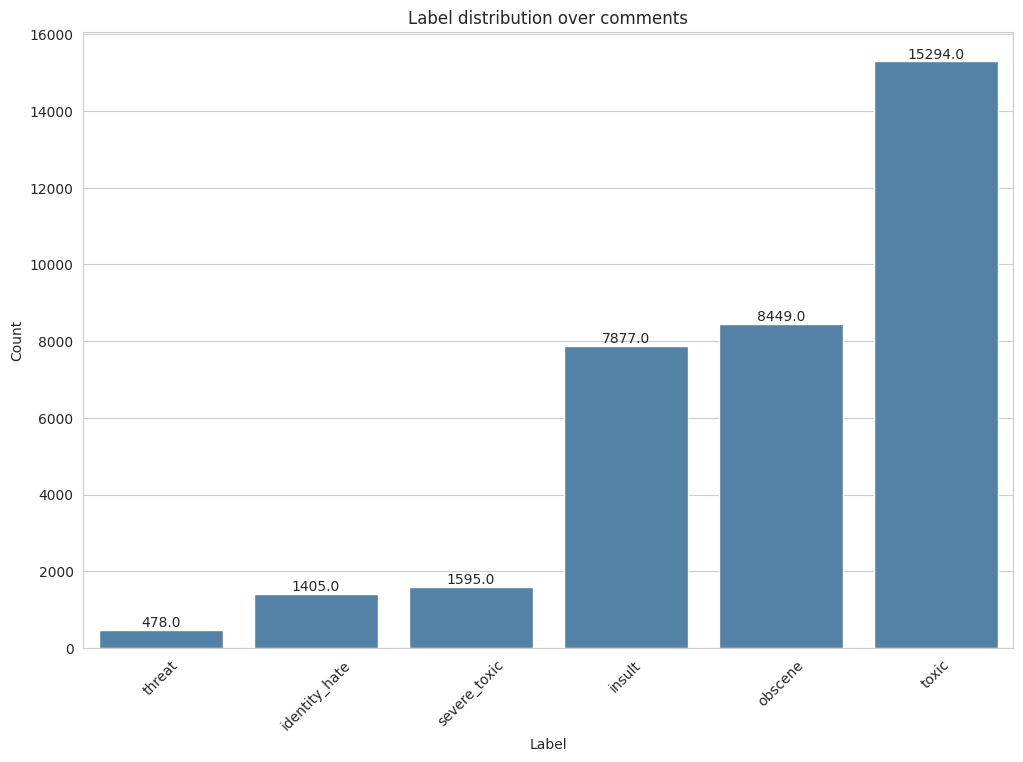

In [24]:
df_distribution = df_train[target_labels].sum()\
                                .to_frame()\
                                .rename(columns={0: 'count'})\
                                .sort_values('count')

sns.set_style("whitegrid")
color = 'steelblue'

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=df_distribution.index, y='count', data=df_distribution, color=color)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Label distribution over comments')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

There are also comments that didn't contain any negative connotation.

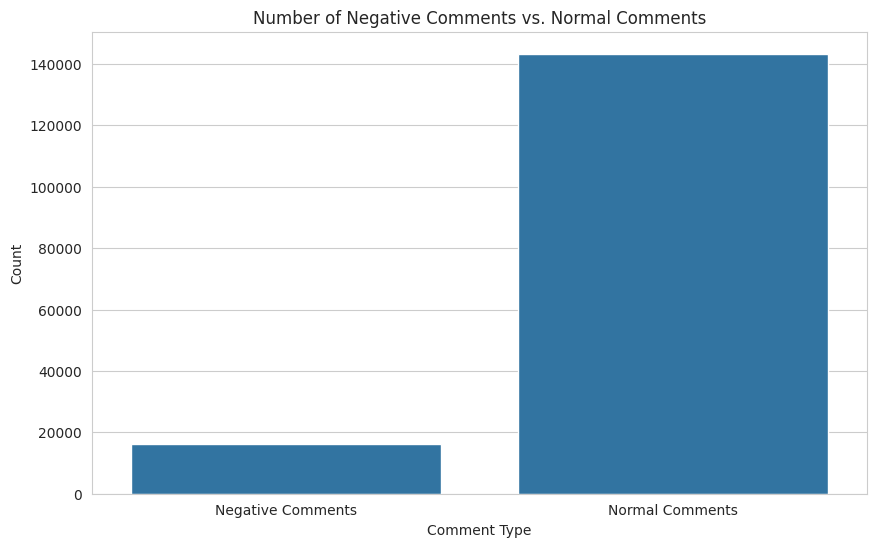

In [25]:
num_neg_comments = len(df_train[df_train[target_labels].sum(axis=1) > 0])

num_norm_comments = len(df_train[df_train[target_labels].sum(axis=1) == 0])

plt.figure(figsize=(10, 6))
sns.barplot(x=['Negative Comments', 'Normal Comments'], y=[num_neg_comments, num_norm_comments])
plt.title('Number of Negative Comments vs. Normal Comments')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.show()

- There is a class imbalance in this dataset. The majority of comments are normal, and among negative comments, the majority are toxic, obscene, or insult.

#### Correlations between the negative labels

We will use Cramer's V association scores. Cramer's V is a measure of association between categorical variables. It ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association.

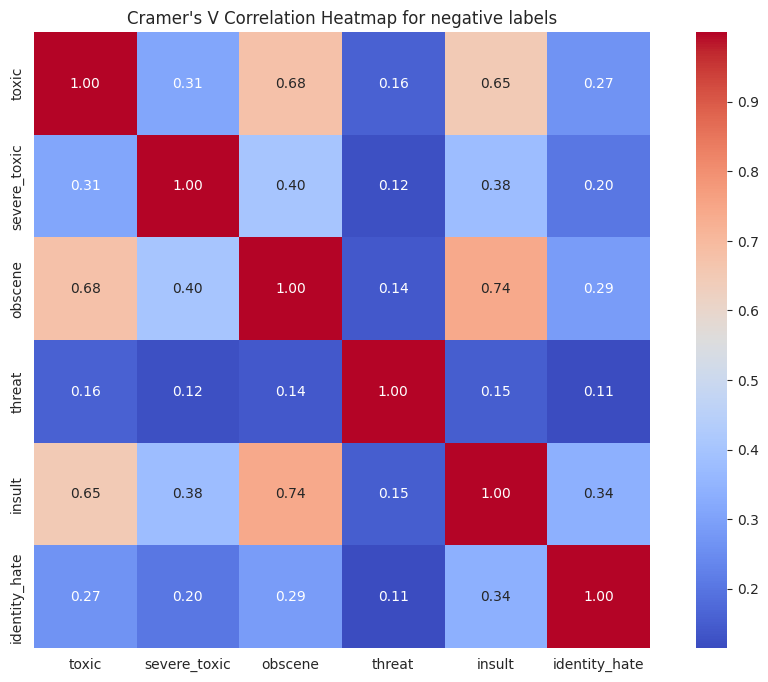

In [26]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def plot_cramers_v_heatmap(df):
    cols = df.columns
    corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    for i in range(len(cols)):
        for j in range(len(cols)):
            corr_matrix.iloc[i, j] = cramers_v(df[cols[i]], df[cols[j]])

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Cramer's V Correlation Heatmap for negative labels")
    plt.show()

plot_cramers_v_heatmap(df_train[target_labels])

- Some of the labels are moderately associated, like: obscene, insult, and toxic. We assume that we can observe these labels appearing together more often than not.

In [27]:
normal_comments = df_train[df_train[target_labels].sum(axis=1) == 0]
negative_comments = df_train[df_train[target_labels].sum(axis=1) > 0]

def extract_features(text):
    num_sentences = text.count('.')
    num_words = len(text.split())
    unique_words = len(set(text.split()))
    return num_sentences, num_words, unique_words

In [28]:
normal_comments['num_sentences'], normal_comments['num_words'], normal_comments['unique_words'] = zip(*normal_comments['clean_text'].apply(extract_features))

negative_comments['num_sentences'], negative_comments['num_words'], negative_comments['unique_words'] = zip(*negative_comments['clean_text'].apply(extract_features))

combined_comments = pd.concat([normal_comments.assign(comment_type='Normal'),
                               negative_comments.assign(comment_type='Negative')])

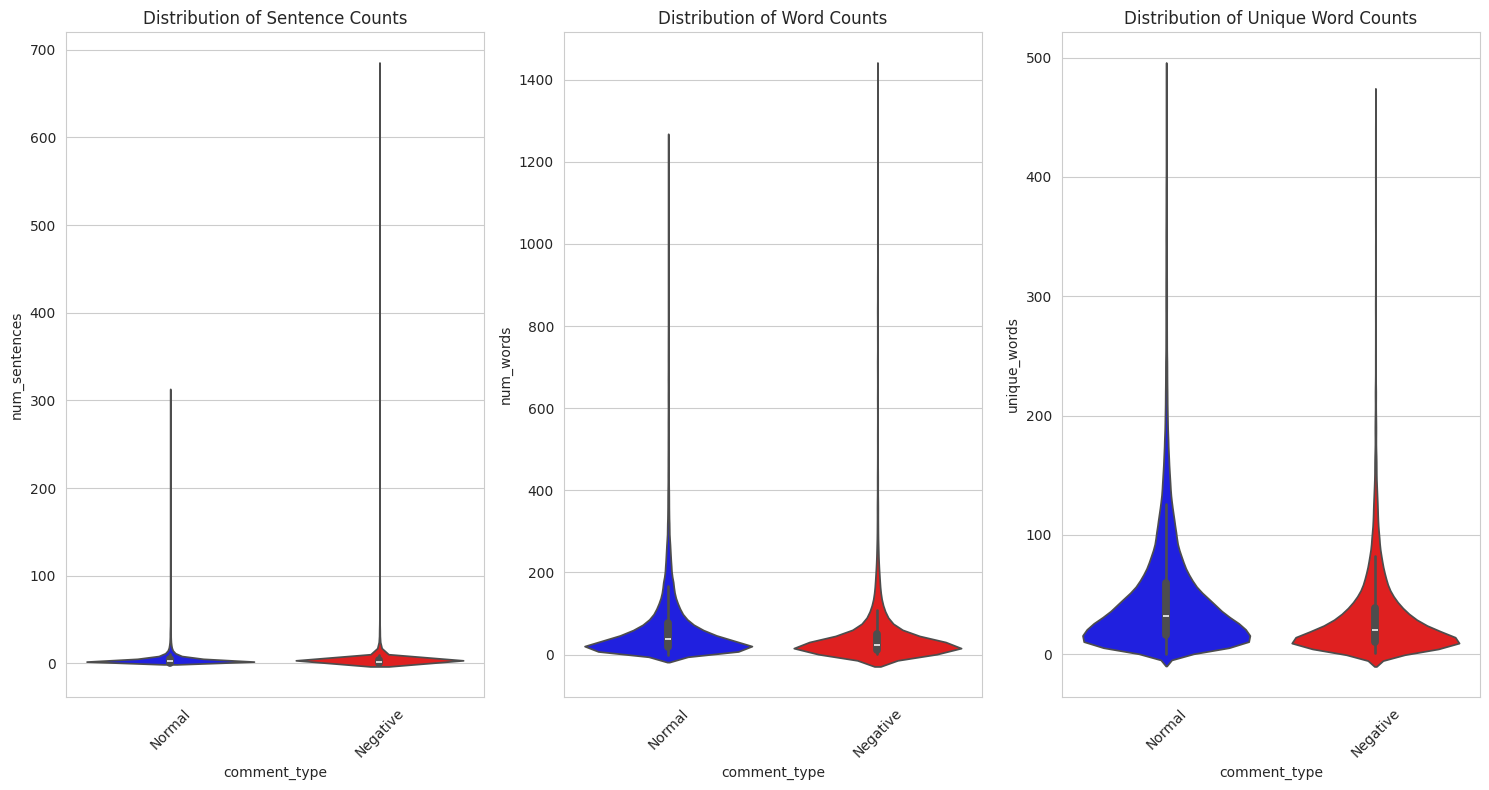

In [29]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.violinplot(x='comment_type', y='num_sentences', data=combined_comments, palette=['blue', 'red'])
plt.title('Distribution of Sentence Counts')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.violinplot(x='comment_type', y='num_words', data=combined_comments, palette=['blue', 'red'])
plt.title('Distribution of Word Counts')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.violinplot(x='comment_type', y='unique_words', data=combined_comments, palette=['blue', 'red'])
plt.title('Distribution of Unique Word Counts')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- Overall there's no drastic difference between normal and negative comments in number of sentences, word counts, and unique word counts. But we can observe that normal comments tend to contain more unique words.

# 2. Building a Multi-Label Classifier

## 2.1. Building the Dataset

First, we will concatenate the labels into one-hot encoded lists:

In [30]:
df_train['labels'] = df_train.iloc[:, 1:-1].values.tolist()
df_test_full['labels'] = df_test_full.iloc[:, 1:-1].values.tolist()

In [31]:
train_df_upd = df_train[["clean_text", "labels"]]
test_df = df_test_full[["clean_text", "labels"]]

train_df_upd.rename(columns={'clean_text': 'text'}, inplace=True)
test_df.rename(columns={'clean_text': 'text'}, inplace=True)

The testing set contains -1 values which mean we don't have real labels for those comments. We will remove comments with such values from our testing dataset.

In [32]:
test_df_reduced = test_df[~test_df['labels'].apply(lambda x: -1 in x)]

In [33]:
display(print("Training data:"), train_df_upd.head())
display(print("Testing data:"), test_df_reduced.head())

Training data:


None

,text,labels
0,explanation why the edits made under my userna...,"[0, 0, 0, 0, 0, 0]"
1,d'aww! he matches this background colour i'm s...,"[0, 0, 0, 0, 0, 0]"
2,"hey man, i'm really not trying to edit war. it...","[0, 0, 0, 0, 0, 0]"
3,""" more i can't make any real suggestions on im...","[0, 0, 0, 0, 0, 0]"
4,"you, sir, are my hero. any chance you remember...","[0, 0, 0, 0, 0, 0]"


Testing data:


None

,text,labels
5,thank you for understanding. i think very high...,"[0, 0, 0, 0, 0, 0]"
7,:dear god this site is horrible.,"[0, 0, 0, 0, 0, 0]"
11,"""::: somebody will invariably try to add relig...","[0, 0, 0, 0, 0, 0]"
13,""" it says it right there that it is a type. th...","[0, 0, 0, 0, 0, 0]"
14,""" == before adding a new product to the list, ...","[0, 0, 0, 0, 0, 0]"


In [34]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
                                                truncation=True,
                                                do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Now, we will build the dataset and train, validation, test dataloaders:

In [35]:
class ToxicCommentsDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
        }

In [36]:
train_df_upd['has_positive_label'] = train_df_upd['labels'].apply(lambda x: 1 if 1 in x else 0)

train_df, val_df = train_test_split(train_df_upd, test_size=0.2,
                                    stratify=train_df_upd['has_positive_label'],
                                    random_state=42)

train_df.drop('has_positive_label', axis=1, inplace=True)
val_df.drop('has_positive_label', axis=1, inplace=True)

train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

Since our dataset is imbalance and the majority of comments are normal, we will downsample the majority class to match the number of comments that have at least one negative label.

In [37]:
from sklearn.utils import resample

normal_comments = train_df[train_df['labels'].apply(lambda x: sum(x)) == 0]
negative_comments = train_df[train_df['labels'].apply(lambda x: sum(x)) > 0]

print("Count of normal comments in training data before downsampling:", len(normal_comments))
print("Count of negative comments in training data before downsampling:", len(negative_comments))

downsampled_normal_comments = resample(normal_comments,
                                       replace=False,
                                       n_samples=len(negative_comments),
                                       random_state=42)

balanced_train_df = pd.concat([downsampled_normal_comments, negative_comments])
balanced_train_df = balanced_train_df.sample(frac=1).reset_index(drop=True)

normal_comments_balanced = balanced_train_df[balanced_train_df['labels'].apply(lambda x: sum(x)) == 0]
negative_comments_balanced = balanced_train_df[balanced_train_df['labels'].apply(lambda x: sum(x)) > 0]

print("-"*20)
print("Count of normal comments in training data after downsampling:", len(normal_comments_balanced))
print("Count of negative comments in training data after downsampling:", len(negative_comments_balanced))

Count of normal comments in training data before downsampling: 114676
Count of negative comments in training data before downsampling: 12980
--------------------
Count of normal comments in training data after downsampling: 12980
Count of negative comments in training data after downsampling: 12980


In [38]:
test_df_reduced = test_df_reduced.reset_index(drop=True)

In [39]:
print("Train Dataset: {}".format(train_df.shape))
print("Downsampled Train Dataset: {}".format(balanced_train_df.shape))
print("Validation Dataset: {}".format(val_df.shape))
print("Test Dataset: {}".format(test_df_reduced.shape))

Train Dataset: (127656, 2)
Downsampled Train Dataset: (25960, 2)
Validation Dataset: (31915, 2)
Test Dataset: (63978, 2)


To reduce the model training and testing time, we will additionally create shorter versions of the dataset with random resampling.

In [40]:
test_df_reduced_short, test_df_reduced_shorter = train_test_split(test_df_reduced, test_size=0.1,
                                                 random_state=42)
test_df_reduced_short = test_df_reduced_short.reset_index(drop=True)
test_df_reduced_shorter = test_df_reduced_shorter.reset_index(drop=True)

In [41]:
resampled_train_df = resample(balanced_train_df,replace=False,
                               n_samples=10000,random_state=42)
resampled_val_df = resample(val_df,replace=False,
                             n_samples=10000,random_state=42)
resampled_train_df = resampled_train_df.reset_index(drop=True)
resampled_val_df = resampled_val_df.reset_index(drop=True)

In [42]:
MAX_LEN = 512
training_set = ToxicCommentsDataset(train_df, tokenizer, MAX_LEN)
training_set_downsampled = ToxicCommentsDataset(balanced_train_df, tokenizer, MAX_LEN)
validation_set = ToxicCommentsDataset(val_df, tokenizer, MAX_LEN)
testing_set = ToxicCommentsDataset(test_df_reduced, tokenizer, MAX_LEN)
testing_set_short = ToxicCommentsDataset(test_df_reduced_short, tokenizer, MAX_LEN)
testing_set_shorter = ToxicCommentsDataset(test_df_reduced_shorter, tokenizer, MAX_LEN)
resampled_train_set = ToxicCommentsDataset(resampled_train_df, tokenizer, MAX_LEN)
resampled_val_set = ToxicCommentsDataset(resampled_val_df, tokenizer, MAX_LEN)

## 2.2. Building the Classifier

### 2.2.1. Defining necessary functions

We will define the function for one of the performance metrics that we will use during the testing stage.

- The Hamming loss is the fraction of labels that are incorrectly predicted.
- Hamming score is a Classification metric featuring a fraction of the predictions that a model got right. It is more suitable for multi-label classification problems. The best possible value is 1 (if a model got all the predictions right), and the worst is 0 (if a model did not make a single correct prediction). More info: https://wiki.cloudfactory.com/docs/mp-wiki/metrics/hamming-score#:~:text=Hamming%20score%20explained,-The%20most%20intuitive&text=To%20define%20the%20term%2C%20in,the%20same%20advantages%20as%20Accuracy.

In [43]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

### 2.2.2. Defining the model class and training the model

We will build a model with the option to freeze the base layers for some number of epochs and then unfreeze them for the rest of the fine-tuning epochs.

In [ ]:
class ToxicCommentsClassifier(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset,
                 num_classes=6, lr=1e-3,
                 amp_level='O1', batch_size=64,
                 num_freeze_epochs=1,
                 threshold=0.5):
        super().__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                                        num_labels=num_classes)
        self.lr = lr
        self.batch_size = batch_size
        self.amp_level = amp_level
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.num_freeze_epochs = num_freeze_epochs + 1
        self.threshold = threshold

        self.loss_fn = nn.BCELoss()

        self.train_losses = []
        self.val_losses = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

        self.current_epoch_counter = 0
        self.total_epoch_counter = 0

        self.optimizer = None

    def freeze_unfreeze_model(self):
        if self.current_epoch_counter < self.num_freeze_epochs:
            for param in self.bert.distilbert.parameters():
                param.requires_grad = False
            print("Freezing the base layers of the model.")
            print("Classification head is trainable.")

            classification_head_params = list(self.bert.classifier.parameters())
            self.optimizer = torch.optim.AdamW([
                {'params': classification_head_params, 'lr': self.lr},
            ], lr=self.lr)
        else:
            for param in self.bert.distilbert.parameters():
                param.requires_grad = True
            self.bert.distilbert.train()
            print("Unfreezing the base layers of the model.")
            print("Classification head is trainable.")

            base_layer_params = list(self.bert.distilbert.parameters())
            classification_head_params = list(self.bert.classifier.parameters())
            self.optimizer = torch.optim.AdamW([
                {'params': base_layer_params, 'lr': self.lr / 10},
                {'params': classification_head_params, 'lr': self.lr},
            ], lr=self.lr)

    def on_fit_start(self):
        self.freeze_unfreeze_model()

    def forward(self, *args, **kwargs):
        outputs = self.bert(*args, **kwargs, output_attentions=True)
        logits = outputs.logits
        attentions = outputs.attentions
        return logits, attentions

    def on_validation_epoch_start(self):
        print(f"Validating Epoch: {self.current_epoch_counter}")
        self.print_freezing_status()

    def on_train_epoch_start(self):
        print(f"Training Epoch: {self.current_epoch_counter}")
        self.print_freezing_status()

    def print_freezing_status(self):
        base_layer_status = "Frozen" if self.current_epoch_counter < self.num_freeze_epochs else "Trainable"
        classification_head_status = "Trainable"
        print(f"Base layers: {base_layer_status}")
        print(f"Classification head: {classification_head_status}")

    def training_step(self, batch, batch_idx):
        input_ids = batch['ids']
        attention_mask = batch['mask']
        targets = batch['targets'].float()
        logits, attentions = self.forward(input_ids=input_ids, attention_mask=attention_mask)
        outputs = torch.sigmoid(logits)
        loss = self.loss_fn(outputs, targets)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        outputs = (outputs >= self.threshold).int()
        unique_targets = torch.unique(targets)

        f1 = f1_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        accuracy = accuracy_score(targets.cpu().numpy(), outputs.cpu().numpy())
        precision = precision_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        recall = recall_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')

        self.log('train_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_precision', precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recall', recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['ids']
        attention_mask = batch['mask']
        targets = batch['targets'].float()
        logits, _ = self.forward(input_ids=input_ids, attention_mask=attention_mask)
        outputs = torch.sigmoid(logits)
        loss = self.loss_fn(outputs, targets)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        outputs = (outputs >= self.threshold).int()
        unique_targets = torch.unique(targets)

        f1 = f1_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        accuracy = accuracy_score(targets.cpu().numpy(), outputs.cpu().numpy())
        precision = precision_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        recall = recall_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')

        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_precision', precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_recall', recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_train_epoch_end(self):
        print(f"Training for epoch: {self.current_epoch_counter}")
        print(f"Total training epochs: {self.total_epoch_counter}")

        avg_train_loss = torch.tensor(self.trainer.callback_metrics['train_loss']).mean().item()
        print(f"avg_train_loss: {avg_train_loss}")
        self.train_losses.append(avg_train_loss)

        avg_train_f1 = torch.tensor(self.trainer.callback_metrics['train_f1']).mean().item()
        print(f"avg_train_f1: {avg_train_f1}")
        self.train_f1.append(avg_train_f1)

        avg_train_accuracy = torch.tensor(self.trainer.callback_metrics['train_accuracy']).mean().item()
        print(f"avg_train_accuracy: {avg_train_accuracy}")
        self.train_accuracy.append(avg_train_accuracy)

        avg_train_precision = torch.tensor(self.trainer.callback_metrics['train_precision']).mean().item()
        print(f"avg_train_precision: {avg_train_precision}")
        self.train_precision.append(avg_train_precision)

        avg_train_recall = torch.tensor(self.trainer.callback_metrics['train_recall']).mean().item()
        print(f"avg_train_recall: {avg_train_recall}")
        self.train_recall.append(avg_train_recall)

        self.freeze_unfreeze_model()

    def on_validation_epoch_end(self):
        print(f"Validating for epoch: {self.current_epoch_counter}")
        print(f"Total validation epochs: {self.total_epoch_counter}")
        if self.current_epoch_counter > 0:
            if 'val_loss' in self.trainer.callback_metrics:
                avg_val_loss = torch.tensor(self.trainer.callback_metrics['val_loss']).mean().item()
                print(f"avg_val_loss: {avg_val_loss}")
                self.val_losses.append(avg_val_loss)

                avg_val_f1 = torch.tensor(self.trainer.callback_metrics['val_f1']).mean().item()
                print(f"avg_val_f1: {avg_val_f1}")
                self.val_f1.append(avg_val_f1)

                avg_val_accuracy = torch.tensor(self.trainer.callback_metrics['val_accuracy']).mean().item()
                print(f"avg_val_accuracy: {avg_val_accuracy}")
                self.val_accuracy.append(avg_val_accuracy)

                avg_val_precision = torch.tensor(self.trainer.callback_metrics['val_precision']).mean().item()
                print(f"avg_val_precision: {avg_val_precision}")
                self.val_precision.append(avg_val_precision)

                avg_val_recall = torch.tensor(self.trainer.callback_metrics['val_recall']).mean().item()
                print(f"avg_val_recall: {avg_val_recall}")
                self.val_recall.append(avg_val_recall)
            else:
                print("No validation metrics for this epoch.")
        self.current_epoch_counter += 1
        self.total_epoch_counter += 1

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)

        scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                   factor=0.5, patience=2,
                                                   verbose=True)
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    def test_model(self, test_dataloader):
        self.eval()
        device = next(self.parameters()).device
        all_targets = []
        all_predictions = []

        pbar = tqdm(total=len(test_dataloader), desc="Testing", unit="batch")
        with torch.no_grad():
            for batch in test_dataloader:
                input_ids = batch['ids'].to(device, dtype=torch.long)
                attention_mask = batch['mask'].to(device)
                targets = batch['targets'].float().to(device)
                logits, _ = self.forward(input_ids=input_ids, attention_mask=attention_mask)
                outputs = torch.sigmoid(logits)
                all_targets.append(targets.cpu().numpy())
                all_predictions.append(outputs.cpu().numpy())
                pbar.update(1)
        pbar.close()

        all_targets = np.concatenate(all_targets, axis=0)
        all_predictions = np.concatenate(all_predictions, axis=0)

        thresholded_predictions = (all_predictions >= self.threshold).astype(int)

        return all_targets, all_predictions, thresholded_predictions

    def plot_metrics(self):
        plt.figure(figsize=(12, 10))

        plt.subplot(2, 3, 1)
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Validation Loss")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(2, 3, 2)
        plt.plot(range(1, len(self.train_f1) + 1), self.train_f1, label="Train F1")
        plt.plot(range(1, len(self.val_f1) + 1), self.val_f1, label="Validation F1")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('F1 Score')
        plt.legend()

        plt.subplot(2, 3, 3)
        plt.plot(range(1, len(self.train_accuracy) + 1), self.train_accuracy, label="Train Accuracy")
        plt.plot(range(1, len(self.val_accuracy) + 1), self.val_accuracy, label="Validation Accuracy")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(2, 3, 4)
        plt.plot(range(1, len(self.train_precision) + 1), self.train_precision, label="Train Precision")
        plt.plot(range(1, len(self.val_precision) + 1), self.val_precision, label="Validation Precision")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.title('Precision')
        plt.legend()

        plt.subplot(2, 3, 5)
        plt.plot(range(1, len(self.train_recall) + 1), self.train_recall, label="Train Recall")
        plt.plot(range(1, len(self.val_recall) + 1), self.val_recall, label="Validation Recall")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.title('Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params
----------------------------------------------------------------
0 | bert    | DistilBertForSequenceClassification | 67.0 M
1 | loss_

Freezing the base layers of the model.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 0
Validating for epoch: 0
Total validation epochs: 0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 1
Validating for epoch: 1
Total validation epochs: 1
avg_val_loss: 0.09300138801336288
avg_val_f1: 0.5374107360839844
avg_val_accuracy: 0.8029000163078308
avg_val_precision: 0.43658316135406494
avg_val_recall: 0.7685961127281189
Training for epoch: 2
Total training epochs: 2
avg_train_loss: 0.2260376513004303
avg_train_f1: 0.7248262166976929
avg_train_accuracy: 0.5938000082969666
avg_train_precision: 0.7468810081481934
avg_train_recall: 0.7204746603965759
Unfreezing the base layers of the model.


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 2
Validating for epoch: 2
Total validation epochs: 2
avg_val_loss: 0.27531978487968445
avg_val_f1: 0.14591501653194427
avg_val_accuracy: 0.03229999914765358
avg_val_precision: 0.09179999679327011
avg_val_recall: 0.4629758894443512
Training for epoch: 3
Total training epochs: 3
avg_train_loss: 0.4707753360271454
avg_train_f1: 0.39583832025527954
avg_train_accuracy: 0.21320000290870667
avg_train_precision: 0.4254293441772461
avg_train_recall: 0.39116886258125305
Unfreezing the base layers of the model.


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 3


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Validating for epoch: 3
Total validation epochs: 3
avg_val_loss: 0.26839742064476013
avg_val_f1: 0.14591501653194427
avg_val_accuracy: 0.03229999914765358
avg_val_precision: 0.09179999679327011
avg_val_recall: 0.4629758894443512
Training for epoch: 4
Total training epochs: 4
avg_train_loss: 0.3830978274345398
avg_train_f1: 0.44557085633277893
avg_train_accuracy: 0.1762000024318695
avg_train_precision: 0.472214013338089
avg_train_recall: 0.4336133301258087
Unfreezing the base layers of the model.


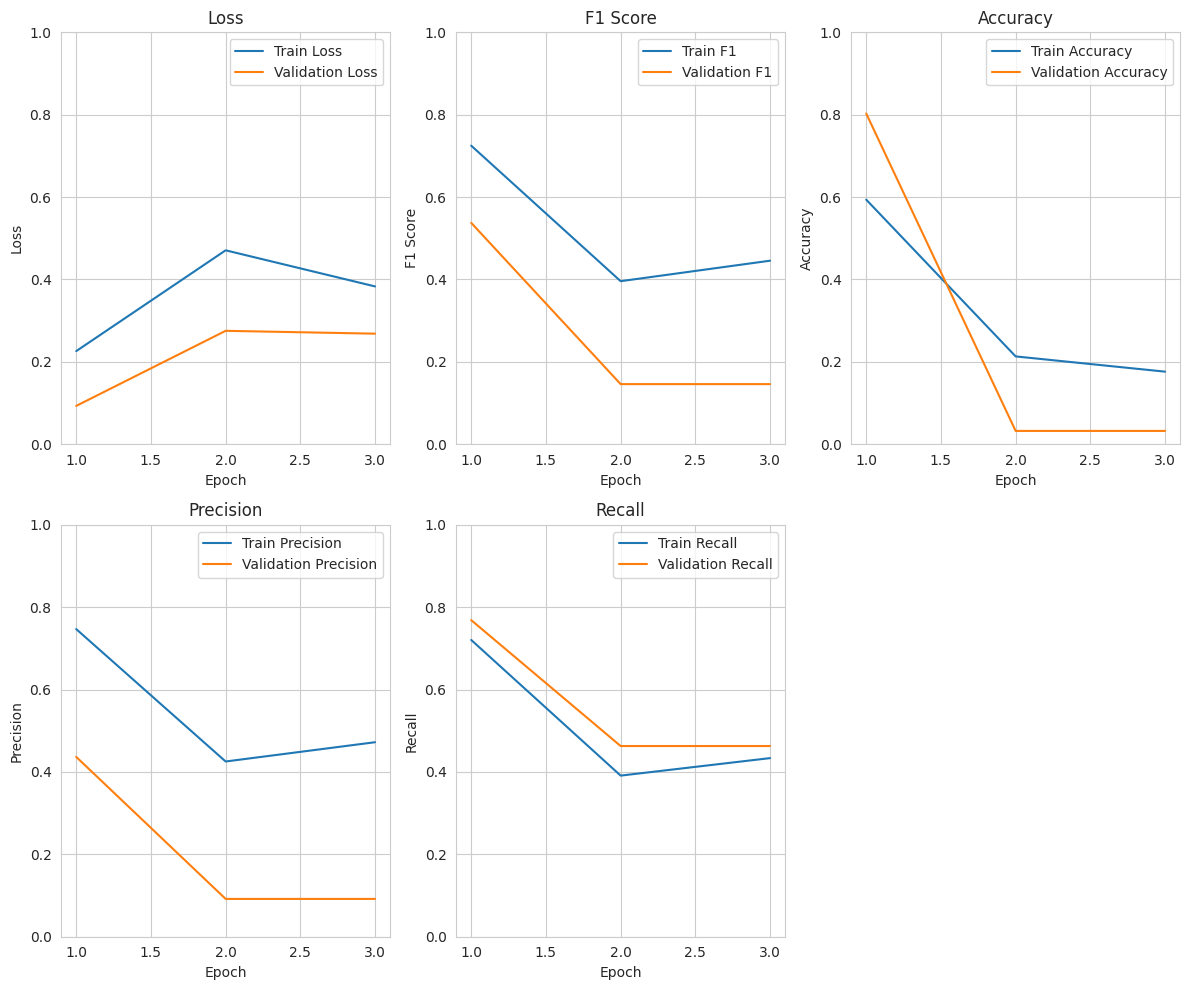

In [ ]:
toxic_comment_classifier_bert = ToxicCommentsClassifier(num_classes=6, train_dataset=training_set_downsampled,
                                             val_dataset=validation_set,
                                             batch_size=32,
                                             num_freeze_epochs=1,
                                             threshold=0.5
                                             )
train_dataloader = toxic_comment_classifier_bert.train_dataloader()
val_dataloader = toxic_comment_classifier_bert.val_dataloader()

callbacks = [
    ModelCheckpoint(
        monitor='val_loss',
        dirpath='./checkpoints',
        filename='best_model',
        save_top_k=1,
        mode='min'
    ),
    LearningRateMonitor(logging_interval='epoch'),
]

toxic_comment_classifier_bert.setup(stage="train")
trainer_args = {
    'callbacks': callbacks,
    'max_epochs': 4,
    'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
    'devices': 1 if torch.cuda.is_available() else None,
}
trainer = pl.Trainer(**trainer_args)
trainer.fit(toxic_comment_classifier_bert, train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

toxic_comment_classifier_bert.plot_metrics()

- We have tried freezing the base layers for 1 epoch and then unfreeze them for 3 fine-tuning epochs with balanced downsampled training dataset. The results seem to deteriorate with each epoch, probably due to forgetting of the pre-trained weights. Further, we will try training only the classification head of the pre-trained DistilBertForSequenceClassification model.

### 2.2.3. Improving the model

Now, we will try to train only the final classification layer of the pre-trained model since DistilBertForSequenceClassification should already be suitable for our problem.

In [44]:
class ToxicCommentsClassifierModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset,
                 num_classes=6, lr=1e-3,
                 amp_level='O1', batch_size=64,
                 threshold=0.5, freeze_base_flag=True):
        super().__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                                        num_labels=num_classes,
                                                                        problem_type="multi_label_classification")
        self.lr = lr
        self.batch_size = batch_size
        self.amp_level = amp_level
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.threshold = threshold

        self.loss_fn = nn.BCELoss()

        self.train_losses = []
        self.val_losses = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []
        self.train_hamming = []
        self.val_hamming = []

        self.current_epoch_counter = 0
        self.total_epoch_counter = 0

        self.optimizer = None
        self.freeze_base_flag = freeze_base_flag

        if self.freeze_base_flag:
            for param in self.bert.distilbert.parameters():
                param.requires_grad = False
            print("Freezing the base layers of the model.")
            print("Classification head is trainable.")
        else:
            print("Default training of the model.")

    def forward(self, *args, **kwargs):
        outputs = self.bert(*args, **kwargs, output_attentions=True)
        logits = outputs.logits
        attentions = outputs.attentions
        return logits, attentions

    def on_validation_epoch_start(self):
        print(f"Validating Epoch: {self.current_epoch_counter}")

    def on_train_epoch_start(self):
        print(f"Training Epoch: {self.current_epoch_counter}")

    def training_step(self, batch, batch_idx):
        input_ids = batch['ids']
        attention_mask = batch['mask']
        targets = batch['targets'].float()
        logits, attentions = self.forward(input_ids=input_ids, attention_mask=attention_mask)
        outputs = torch.sigmoid(logits)
        loss = self.loss_fn(outputs, targets)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        outputs = (outputs >= self.threshold).int()
        unique_targets = torch.unique(targets)

        f1 = f1_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        accuracy = accuracy_score(targets.cpu().numpy(), outputs.cpu().numpy())
        precision = precision_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        recall = recall_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        hamming = metrics.hamming_loss(targets.cpu().numpy(), outputs.cpu().numpy())

        self.log('train_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_precision', precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recall', recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_hamming', hamming, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['ids']
        attention_mask = batch['mask']
        targets = batch['targets'].float()
        logits, _ = self.forward(input_ids=input_ids, attention_mask=attention_mask)
        outputs = torch.sigmoid(logits)
        loss = self.loss_fn(outputs, targets)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        outputs = (outputs >= self.threshold).int()
        unique_targets = torch.unique(targets)

        f1 = f1_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        accuracy = accuracy_score(targets.cpu().numpy(), outputs.cpu().numpy())
        precision = precision_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        recall = recall_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
        hamming = metrics.hamming_loss(targets.cpu().numpy(), outputs.cpu().numpy())

        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_precision', precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_recall', recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_hamming', hamming, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def on_train_epoch_end(self):
        print(f"Training for epoch: {self.current_epoch_counter}")
        print(f"Total training epochs: {self.total_epoch_counter}")

        avg_train_loss = torch.tensor(self.trainer.callback_metrics['train_loss']).mean().item()
        print(f"avg_train_loss: {avg_train_loss}")
        self.train_losses.append(avg_train_loss)

        avg_train_f1 = torch.tensor(self.trainer.callback_metrics['train_f1']).mean().item()
        print(f"avg_train_f1: {avg_train_f1}")
        self.train_f1.append(avg_train_f1)

        avg_train_accuracy = torch.tensor(self.trainer.callback_metrics['train_accuracy']).mean().item()
        print(f"avg_train_accuracy: {avg_train_accuracy}")
        self.train_accuracy.append(avg_train_accuracy)

        avg_train_precision = torch.tensor(self.trainer.callback_metrics['train_precision']).mean().item()
        print(f"avg_train_precision: {avg_train_precision}")
        self.train_precision.append(avg_train_precision)

        avg_train_recall = torch.tensor(self.trainer.callback_metrics['train_recall']).mean().item()
        print(f"avg_train_recall: {avg_train_recall}")
        self.train_recall.append(avg_train_recall)

        avg_train_hamming = torch.tensor(self.trainer.callback_metrics['train_hamming']).mean().item()
        print(f"avg_train_hamming: {avg_train_hamming}")
        self.train_hamming.append(avg_train_hamming)

    def on_validation_epoch_end(self):
        print(f"Validating for epoch: {self.current_epoch_counter}")
        print(f"Total validation epochs: {self.total_epoch_counter}")
        if self.current_epoch_counter > 0:
            if 'val_loss' in self.trainer.callback_metrics:
                avg_val_loss = torch.tensor(self.trainer.callback_metrics['val_loss']).mean().item()
                print(f"avg_val_loss: {avg_val_loss}")
                self.val_losses.append(avg_val_loss)

                avg_val_f1 = torch.tensor(self.trainer.callback_metrics['val_f1']).mean().item()
                print(f"avg_val_f1: {avg_val_f1}")
                self.val_f1.append(avg_val_f1)

                avg_val_accuracy = torch.tensor(self.trainer.callback_metrics['val_accuracy']).mean().item()
                print(f"avg_val_accuracy: {avg_val_accuracy}")
                self.val_accuracy.append(avg_val_accuracy)

                avg_val_precision = torch.tensor(self.trainer.callback_metrics['val_precision']).mean().item()
                print(f"avg_val_precision: {avg_val_precision}")
                self.val_precision.append(avg_val_precision)

                avg_val_recall = torch.tensor(self.trainer.callback_metrics['val_recall']).mean().item()
                print(f"avg_val_recall: {avg_val_recall}")
                self.val_recall.append(avg_val_recall)

                avg_val_hamming = torch.tensor(self.trainer.callback_metrics['val_hamming']).mean().item()
                print(f"avg_val_hamming: {avg_val_hamming}")
                self.val_hamming.append(avg_val_hamming)
            else:
                print("No validation metrics for this epoch.")
        self.current_epoch_counter += 1
        self.total_epoch_counter += 1

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def configure_optimizers(self):
        optimizer_params = self.parameters() if not self.freeze_base_flag else self.bert.classifier.parameters()
        optimizer = torch.optim.AdamW(optimizer_params, lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                               factor=0.5, patience=2,
                                                               verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'train_loss',
            }
        }


    def test_model(self, test_dataloader, threshold=None):
        self.eval()
        device = next(self.parameters()).device
        all_targets, all_predictions = [], []

        if threshold is None:
            threshold = self.threshold

        pbar = tqdm(total=len(test_dataloader), desc="Testing", unit="batch")
        with torch.no_grad():
            for batch in test_dataloader:
                input_ids = batch['ids'].to(device)
                attention_mask = batch['mask'].to(device)
                targets = batch['targets'].to(device)

                logits, _ = self(input_ids, attention_mask)

                outputs = torch.sigmoid(logits)
                all_targets.append(targets.cpu().numpy())
                all_predictions.append(outputs.cpu().numpy())
                pbar.update(1)
        pbar.close()

        all_targets = np.concatenate(all_targets, axis=0)
        all_predictions = np.concatenate(all_predictions, axis=0)
        thresholded_predictions = (all_predictions >= threshold).astype(int)

        return all_targets, all_predictions, thresholded_predictions


    def plot_metrics(self):
        plt.figure(figsize=(12, 12))

        plt.subplot(3, 3, 1)
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Validation Loss")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(3, 3, 2)
        plt.plot(range(1, len(self.train_f1) + 1), self.train_f1, label="Train F1")
        plt.plot(range(1, len(self.val_f1) + 1), self.val_f1, label="Validation F1")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('F1 Score')
        plt.legend()

        plt.subplot(3, 3, 3)
        plt.plot(range(1, len(self.train_accuracy) + 1), self.train_accuracy, label="Train Accuracy")
        plt.plot(range(1, len(self.val_accuracy) + 1), self.val_accuracy, label="Validation Accuracy")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(3, 3, 4)
        plt.plot(range(1, len(self.train_precision) + 1), self.train_precision, label="Train Precision")
        plt.plot(range(1, len(self.val_precision) + 1), self.val_precision, label="Validation Precision")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.title('Precision')
        plt.legend()

        plt.subplot(3, 3, 5)
        plt.plot(range(1, len(self.train_recall) + 1), self.train_recall, label="Train Recall")
        plt.plot(range(1, len(self.val_recall) + 1), self.val_recall, label="Validation Recall")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.title('Recall')
        plt.legend()

        plt.subplot(3, 3, 6)
        plt.plot(range(1, len(self.train_hamming) + 1), self.train_hamming, label="Train Hamming")
        plt.plot(range(1, len(self.val_hamming) + 1), self.val_hamming, label="Validation Hamming")
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Hamming Score')
        plt.title('Hamming Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params
----------------------------------------------------------------
0 | bert    | DistilBertForSequenceClassification | 67.0 M
1 | loss_

Freezing the base layers of the model.
Classification head is trainable.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 0
Validating for epoch: 0
Total validation epochs: 0


Training: |          | 0/? [00:00<?, ?it/s]

Training Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 1
Validating for epoch: 1
Total validation epochs: 1
avg_val_loss: 0.14135314524173737
avg_val_f1: 0.49117910861968994
avg_val_accuracy: 0.8163245916366577
avg_val_precision: 0.4563439190387726
avg_val_recall: 0.5979400277137756
avg_val_hamming: 0.03803853690624237
Training for epoch: 2
Total training epochs: 2
avg_train_loss: 0.2938840687274933
avg_train_f1: 0.5850193500518799
avg_train_accuracy: 0.5668721199035645
avg_train_precision: 0.8285771608352661
avg_train_recall: 0.4687626361846924
avg_train_hamming: 0.11449030786752701
Training Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 2
Validating for epoch: 2
Total validation epochs: 2
avg_val_loss: 0.11181916296482086
avg_val_f1: 0.5277653336524963
avg_val_accuracy: 0.8454018235206604
avg_val_precision: 0.5069068670272827
avg_val_recall: 0.6070934534072876
avg_val_hamming: 0.03297819569706917
Training for epoch: 3
Total training epochs: 3
avg_train_loss: 0.23520222306251526
avg_train_f1: 0.6935014724731445
avg_train_accuracy: 0.6140986084938049
avg_train_precision: 0.8167702555656433
avg_train_recall: 0.6099896430969238
avg_train_hamming: 0.09466488659381866
Training Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 3
Validating for epoch: 3
Total validation epochs: 3
avg_val_loss: 0.10038962215185165
avg_val_f1: 0.5516489148139954
avg_val_accuracy: 0.866395115852356
avg_val_precision: 0.5477859377861023
avg_val_recall: 0.6094987392425537
avg_val_hamming: 0.029500242322683334
Training for epoch: 4
Total training epochs: 4
avg_train_loss: 0.2217634618282318
avg_train_f1: 0.7107810974121094
avg_train_accuracy: 0.6232280135154724
avg_train_precision: 0.8158500790596008
avg_train_recall: 0.6377217173576355
avg_train_hamming: 0.09122372418642044
Training Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 4


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Validating for epoch: 4
Total validation epochs: 4
avg_val_loss: 0.106235072016716
avg_val_f1: 0.545108437538147
avg_val_accuracy: 0.8449945449829102
avg_val_precision: 0.5014766454696655
avg_val_recall: 0.6563055515289307
avg_val_hamming: 0.033197544515132904
Training for epoch: 5
Total training epochs: 5
avg_train_loss: 0.2150225043296814
avg_train_f1: 0.7208265066146851
avg_train_accuracy: 0.6302003264427185
avg_train_precision: 0.8180691003799438
avg_train_recall: 0.6524668335914612
avg_train_hamming: 0.08868128806352615


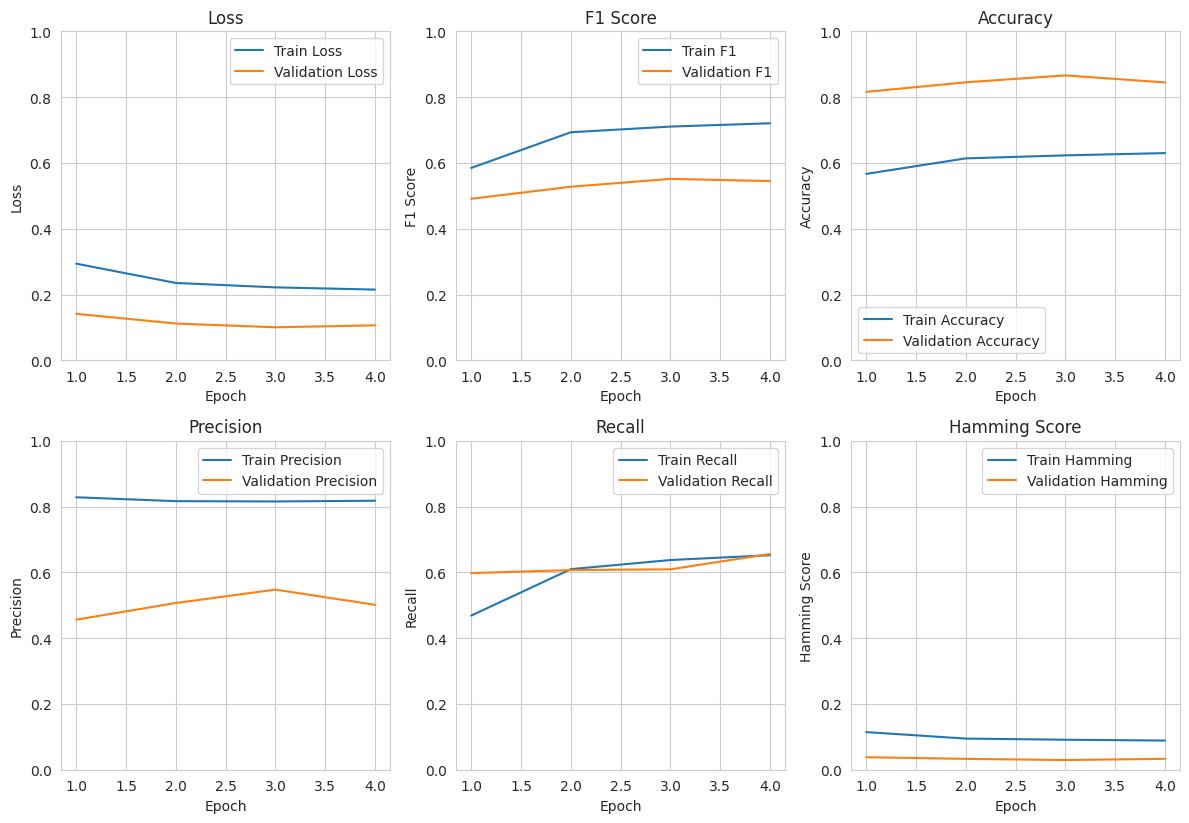

In [ ]:
toxic_comment_classifier_bert = ToxicCommentsClassifierModel(num_classes=6, train_dataset=training_set_downsampled,
                                             val_dataset=validation_set,
                                             batch_size=32,
                                             threshold=0.5
                                             )
train_dataloader = toxic_comment_classifier_bert.train_dataloader()
val_dataloader = toxic_comment_classifier_bert.val_dataloader()

callbacks = [
    ModelCheckpoint(
        monitor='val_loss',
        dirpath='./checkpoints',
        filename='best_model',
        save_top_k=1,
        mode='min'
    ),
    LearningRateMonitor(logging_interval='epoch'),
]

toxic_comment_classifier_bert.setup(stage="train")
trainer_args = {
    'callbacks': callbacks,
    'max_epochs': 4,
    'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
    'devices': 1 if torch.cuda.is_available() else None,
}
trainer = pl.Trainer(**trainer_args)
trainer.fit(toxic_comment_classifier_bert, train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

toxic_comment_classifier_bert.plot_metrics()

In [ ]:
path_pickle = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/toxic_comment_classifier_bert.pkl'
with open(path_pickle, 'wb') as f:
    pickle.dump(toxic_comment_classifier_bert, f)

path_torch = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/toxic_comment_classifier_bert.pth'
torch.save(toxic_comment_classifier_bert.state_dict(), path_torch)

In [77]:
path_pickle = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/toxic_comment_classifier_bert.pkl'

with open(path_pickle, 'rb') as f:
    toxic_comment_classifier_bert = pickle.load(f)

#### Integrating a learning rate finder

In [45]:
toxic_comment_classifier_lr = ToxicCommentsClassifierModel(num_classes=6,
                                                           train_dataset=training_set_downsampled,
                                             val_dataset=validation_set,
                                             batch_size=32,
                                             threshold=0.5,
                                             freeze_base_flag=False,
                                             )
train_dataloader = toxic_comment_classifier_lr.train_dataloader()
val_dataloader = toxic_comment_classifier_lr.val_dataloader()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Default training of the model.


In [99]:
from pytorch_lightning.callbacks import LearningRateFinder

def find_lr(model, train_dataloader, val_dataloader, min_lr=1e-8, max_lr=1,
            num_training_steps=100, mode='exponential', early_stop_threshold=4.0,
            update_attr=True, attr_name=''):
    lr_finder = LearningRateFinder(min_lr=min_lr, max_lr=max_lr,
                                   num_training_steps=num_training_steps,
                                   mode=mode, early_stop_threshold=early_stop_threshold,
                                   update_attr=update_attr, attr_name=attr_name)
    trainer = pl.Trainer(callbacks=[lr_finder], max_epochs=1)
    trainer.fit(model, train_dataloader, val_dataloader)

    return lr_finder

In [47]:
new_lr = find_lr(toxic_comment_classifier_lr, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Epoch: 0
Validating Epoch: 0
Validating for epoch: 0
Total validation epochs: 0


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validating Epoch: 1


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 91 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0001445439770745928
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6db1b681-0789-408c-90c0-cdb51809d10f.ckpt


Validating for epoch: 1
Total validation epochs: 1
avg_val_loss: 35.00520706176758
avg_val_f1: 0.04767313599586487
avg_val_accuracy: 0.0
avg_val_precision: 0.027499999850988388
avg_val_recall: 0.23339028656482697
avg_val_hamming: 0.3500521183013916
Training for epoch: 2
Total training epochs: 2
avg_train_loss: 1.3208820819854736
avg_train_f1: 0.2866428792476654
avg_train_accuracy: 0.2166895568370819
avg_train_precision: 0.36595383286476135
avg_train_recall: 0.38738182187080383
avg_train_hamming: 0.403617262840271


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6db1b681-0789-408c-90c0-cdb51809d10f.ckpt
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params
----------------------------------------------------------------
0 | bert    | DistilBertForSequenceClassification | 67.0 M
1 | loss_fn | BCELoss                             | 0     
----------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.832   Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6db1b681-0789-408c-90c0-cdb51809d10f.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 2
Validating for epoch: 2
Total validation epochs: 2
avg_val_loss: 0.7214772701263428
avg_val_f1: 0.04970402270555496
avg_val_accuracy: 0.0
avg_val_precision: 0.026842530816793442
avg_val_recall: 0.442307710647583
avg_val_hamming: 0.6927083730697632


Training: |          | 0/? [00:00<?, ?it/s]

Training Epoch: 3
Training for epoch: 3
Total training epochs: 3
avg_train_loss: 0.3847425878047943
avg_train_f1: 0.12763026356697083
avg_train_accuracy: 0.4078444838523865
avg_train_precision: 0.13619379699230194
avg_train_recall: 0.12570136785507202
avg_train_hamming: 0.1842675507068634


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [48]:
optimal_lr = 0.0001445439770745928

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                                | Params
----------------------------------------------------------------
0 | bert    | DistilBertForSequenceClassification | 67.0 M
1 | loss_

Default training of the model.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 0
Validating for epoch: 0
Total validation epochs: 0


Training: |          | 0/? [00:00<?, ?it/s]

Training Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 1
Validating for epoch: 1
Total validation epochs: 1
avg_val_loss: 0.0671100988984108
avg_val_f1: 0.6336196660995483
avg_val_accuracy: 0.8587811589241028
avg_val_precision: 0.5550183057785034
avg_val_recall: 0.7947078943252563
avg_val_hamming: 0.02697790414094925
Training for epoch: 2
Total training epochs: 2
avg_train_loss: 0.17267316579818726
avg_train_f1: 0.7891992926597595
avg_train_accuracy: 0.6741525530815125
avg_train_precision: 0.8241630792617798
avg_train_recall: 0.7703715562820435
avg_train_hamming: 0.072245754301548
Training Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 2
Validating for epoch: 2
Total validation epochs: 2
avg_val_loss: 0.08415396511554718
avg_val_f1: 0.5670437812805176
avg_val_accuracy: 0.7990913391113281
avg_val_precision: 0.46507570147514343
avg_val_recall: 0.8015444278717041
avg_val_hamming: 0.037281326949596405
Training for epoch: 3
Total training epochs: 3
avg_train_loss: 0.13161586225032806
avg_train_f1: 0.8406095504760742
avg_train_accuracy: 0.7364792227745056
avg_train_precision: 0.8516557216644287
avg_train_recall: 0.8356438279151917
avg_train_hamming: 0.056195441633462906
Training Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 3
Validating for epoch: 3
Total validation epochs: 3
avg_val_loss: 0.04934711009263992
avg_val_f1: 0.6726675629615784
avg_val_accuracy: 0.9029296636581421
avg_val_precision: 0.6673506498336792
avg_val_recall: 0.7149640917778015
avg_val_hamming: 0.019813047721982002
Training for epoch: 4
Total training epochs: 4
avg_train_loss: 0.10781167447566986
avg_train_f1: 0.873249351978302
avg_train_accuracy: 0.7825115323066711
avg_train_precision: 0.8756417036056519
avg_train_recall: 0.8757643103599548
avg_train_hamming: 0.0451849140226841
Training Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

Validating Epoch: 4


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Validating for epoch: 4
Total validation epochs: 4
avg_val_loss: 0.06869332492351532
avg_val_f1: 0.6209003925323486
avg_val_accuracy: 0.8558984994888306
avg_val_precision: 0.5437583923339844
avg_val_recall: 0.7790349721908569
avg_val_hamming: 0.028356563299894333
Training for epoch: 5
Total training epochs: 5
avg_train_loss: 0.08701715618371964
avg_train_f1: 0.9019718766212463
avg_train_accuracy: 0.8255777955055237
avg_train_precision: 0.9022703170776367
avg_train_recall: 0.905344545841217
avg_train_hamming: 0.035066764801740646


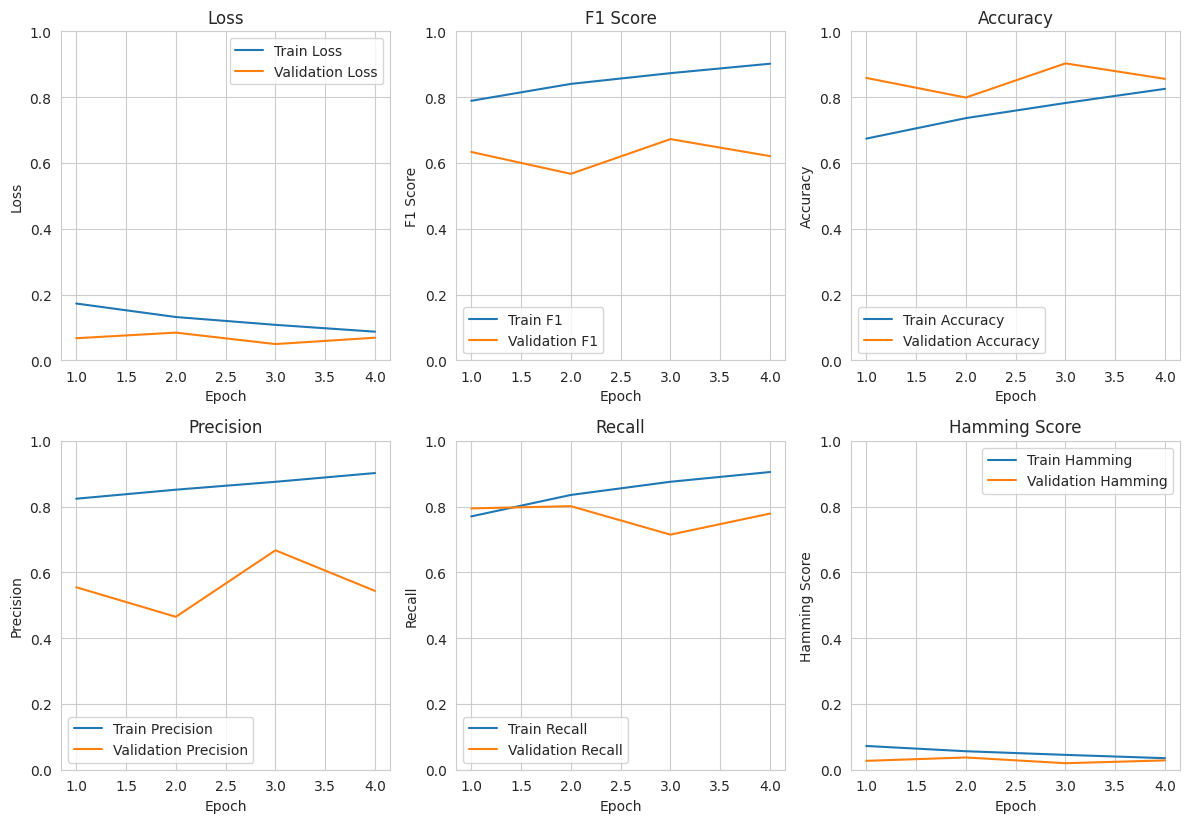

In [49]:
toxic_comment_classifier_lr_upd = ToxicCommentsClassifierModel(num_classes=6,
                                                           train_dataset=training_set_downsampled,
                                             val_dataset=validation_set,
                                             batch_size=32,
                                             threshold=0.5,
                                             freeze_base_flag=False,
                                             lr=optimal_lr,
                                             )
train_dataloader = toxic_comment_classifier_lr_upd.train_dataloader()
val_dataloader = toxic_comment_classifier_lr_upd.val_dataloader()

callbacks = [
    ModelCheckpoint(
        monitor='val_loss',
        dirpath='./checkpoints',
        filename='best_model',
        save_top_k=1,
        mode='min'
    ),
    LearningRateMonitor(logging_interval='epoch'),
]

toxic_comment_classifier_lr_upd.setup(stage="train")
trainer_args = {
    'callbacks': callbacks,
    'max_epochs': 4,
    'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
    'devices': 1 if torch.cuda.is_available() else None,
}
trainer = pl.Trainer(**trainer_args)
trainer.fit(toxic_comment_classifier_lr_upd, train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

toxic_comment_classifier_lr_upd.plot_metrics()

In [50]:
path_pickle = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/toxic_comment_classifier_lr_upd.pkl'
with open(path_pickle, 'wb') as f:
    pickle.dump(toxic_comment_classifier_lr_upd, f)

path_torch = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/toxic_comment_classifier_lr_upd.pth'
torch.save(toxic_comment_classifier_lr_upd.state_dict(), path_torch)

In [45]:
path_pickle = '/content/drive/MyDrive/Turing College/Module 4 - Deep Learning/Project_M4_S2_ToxicCommentClassifier/toxic_comment_classifier_lr_upd.pkl'

with open(path_pickle, 'rb') as f:
    toxic_comment_classifier_lr_upd = pickle.load(f)

## 2.3. Testing the classifier

Let's define the testing function and test dataloaders:

In [78]:
def test_model(model, test_dataloader, threshold=None):
    model.eval()
    device = next(model.parameters()).device
    all_targets, all_predictions = [], []

    if threshold is None:
        threshold = model.threshold

    pbar = tqdm(total=len(test_dataloader), desc="Testing", unit="batch")

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            logits, _ = model(input_ids, attention_mask)
            outputs = torch.sigmoid(logits)

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())

            pbar.update(1)

    pbar.close()

    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    thresholded_predictions = (all_predictions >= threshold).astype(int)

    return all_targets, all_predictions, thresholded_predictions

In [46]:
test_params = {'batch_size': 32,
                'shuffle': False,
                'num_workers': 0
                }

In [48]:
test_dataloader = DataLoader(testing_set, **test_params)
test_dataloader_short = DataLoader(testing_set_short, **test_params)
test_dataloader_shorter = DataLoader(testing_set_shorter, **test_params)

Due to the lack of computational resources, we will use the shorter version of the testing dataset (randomly sampled).

#### Testing the model with default learning rate

In [ ]:
targets, predictions, thresholded_predictions = toxic_comment_classifier_bert.test_model(test_dataloader_shorter)

Testing: 100%|██████████| 200/200 [31:53<00:00,  9.57s/batch]


Now, let's define the function to help us find optimal threshold:

In [63]:
def calculate_metrics(y_true, y_prob, thresholds=np.arange(0.1, 1.0, 0.01)):
    metrics = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, average='micro')
        recall = recall_score(y_true, y_pred, average='micro')
        f1 = f1_score(y_true, y_pred, average='micro')
        hamming = sklearn.metrics.hamming_loss(y_true, y_pred)
        metrics.append((threshold, precision, recall, f1, hamming))

    f1_diffs = np.diff([m[3] for m in metrics])

    elbow_idx = np.argmax(np.abs(np.diff(f1_diffs))) + 1

    best_threshold, best_precision, best_recall, best_f1, best_hamming = metrics[elbow_idx]
    print(f"Best threshold: {best_threshold:.2f}")
    print(f"Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1-score: {best_f1:.4f}, Hamming loss: {best_hamming:.4f}")

    return metrics

In [ ]:
val_metrics = calculate_metrics(targets, predictions)

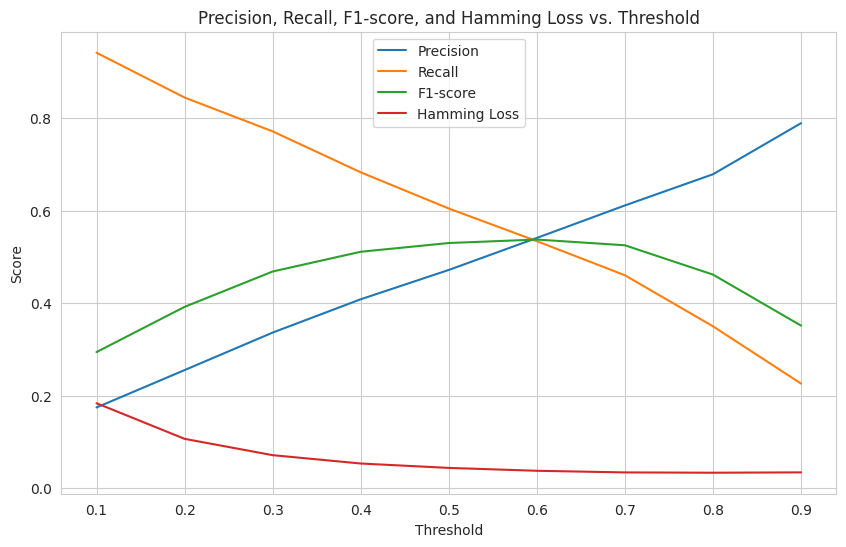

In [ ]:
thresholds, precisions, recalls, f1_scores, hamming_losses = zip(*val_metrics)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, hamming_losses, label='Hamming Loss')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score, and Hamming Loss vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

We can observe that the optimal threshold is 0.6 to get the best precision-recall, F1 score, and Hamming loss ratio.

In [ ]:
thresholded_predictions = (predictions >= 0.6).astype(int)
print(classification_report(targets, thresholded_predictions, target_names=target_labels))

               precision    recall  f1-score   support

        toxic       0.46      0.75      0.57       644
 severe_toxic       0.17      0.03      0.04        39
      obscene       0.70      0.54      0.61       394
       threat       0.00      0.00      0.00        26
       insult       0.79      0.36      0.49       375
identity_hate       0.00      0.00      0.00        80

    micro avg       0.54      0.53      0.54      1558
    macro avg       0.35      0.28      0.29      1558
 weighted avg       0.56      0.53      0.51      1558
  samples avg       0.07      0.05      0.06      1558



- Based on the classification report, the model is able to classify toxic, obscene, and insulting comments better. We should keep in mind that the classes are imbalanced in the testing dataset.

Now, let's calculate the Hamming Loss and Score which are often used with multi-label classification problems:

In [ ]:
val_hamming_loss = sklearn.metrics.hamming_loss(targets, (predictions >= 0.6).astype(int))
val_hamming_score = hamming_score(np.array(targets), np.array((predictions >= 0.6).astype(int)))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.8603339585287068
Hamming Loss = 0.03730332395540273


Hamming loss and score are relatively good.

- Overall, this model performs good based on Hamming score and loss, but since our dataset is imbalanced, other metrics like recall, precision, F1-score require improvement.

#### Testing the model with updated learning rate (using the learning rate finder)

In [51]:
test_targets, test_predictions, test_thresholded_predictions = test_model(toxic_comment_classifier_lr_upd,
                                                                          test_dataloader_shorter,
                                                                          threshold=0.6)

Testing: 100%|██████████| 200/200 [25:45<00:00,  7.73s/batch]


In [64]:
test_metrics = calculate_metrics(test_targets, test_predictions, thresholds=np.arange(0.1, 1.0, 0.01))

Best threshold: 0.98
Precision: 0.8394, Recall: 0.2818, F1-score: 0.4219, Hamming loss: 0.0313


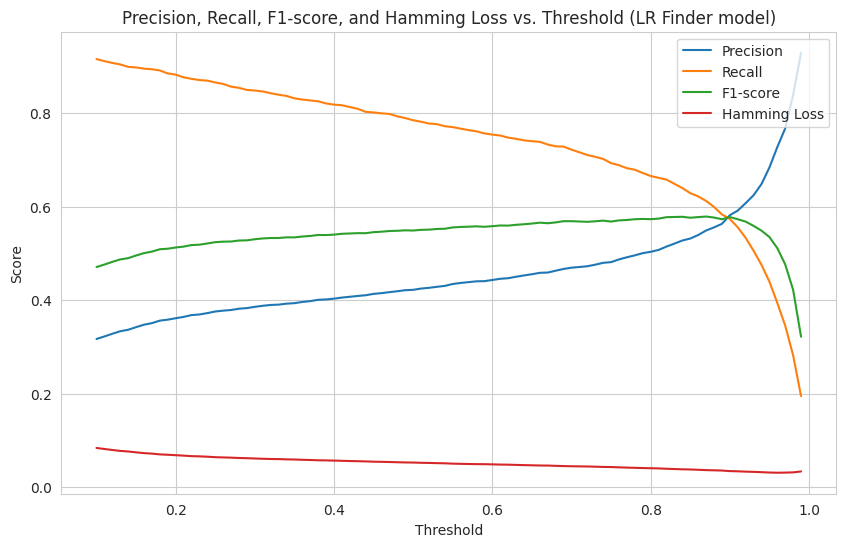

In [65]:
thresholds, precisions, recalls, f1_scores, hamming_losses = zip(*test_metrics)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, hamming_losses, label='Hamming Loss')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score, and Hamming Loss vs. Threshold (LR Finder model)')
plt.legend()
plt.grid(True)
plt.show()

We can observe that the optimal threshold is 0.98 to get the best precision-recall, F1 score, and Hamming loss ratio.

In [70]:
thresholded_predictions_test = (test_predictions >= 0.98).astype(int)
print(classification_report(test_targets, thresholded_predictions_test, target_names=target_labels))

               precision    recall  f1-score   support

        toxic       0.79      0.42      0.55       644
 severe_toxic       0.00      0.00      0.00        39
      obscene       0.91      0.34      0.49       394
       threat       0.00      0.00      0.00        26
       insult       1.00      0.10      0.18       375
identity_hate       0.00      0.00      0.00        80

    micro avg       0.84      0.28      0.42      1558
    macro avg       0.45      0.14      0.20      1558
 weighted avg       0.80      0.28      0.39      1558
  samples avg       0.04      0.03      0.03      1558



In [71]:
test_hamming_loss = sklearn.metrics.hamming_loss(test_targets, (test_predictions >= 0.98).astype(int))
test_hamming_score = hamming_score(np.array(test_targets), np.array((test_predictions >= 0.98).astype(int)))

print(f"Hamming Score = {test_hamming_score}")
print(f"Hamming Loss = {test_hamming_loss}")

Hamming Score = 0.9115061998541211
Hamming Loss = 0.031337918099406066


- After testing the model trained with an optimal initial learning rate (using LR Finder), we can observe that the Hamming score and loss are generally better, but the optimal threshold is pretty high (0.98), and we have lower recall.

# 3. Conclusions and further analysis

## Observations:
- The dataset contains uncleaned text data that was preprocessed with manual cleaning (we got rid of links, emojis, non-ASCII characters, empty spaces, and we lowercased the text) and with a pre-trained tokenizer.
- This dataset is imbalanced, so we've downsampled the majority class in the training set. The majority of comments in the dataset are normal (have all zeros on the target labels).
- Freezing the base layers for 1 epoch and then unfreezing them for 3 fine-tuning epochs with a balanced downsampled training dataset gave the results that seemed to deteriorate with each epoch, probably due to forgetting of the pre-trained weights.
- The model with all base layers frozen performed better in terms of BCE loss and other metrics, compared to freezing/unfreezing model.
- The model with frozen base layers and trained with a commonly used learning rate performs well in terms of Hamming loss and score, but other metrics require improvement.
- The model with frozen base layers and trained with automatically found optimal learning rate performs a bit better in terms of Hamming loss and score, but recall is significantly worse (we may get a higher recall if we lower the threshold which is 0.98 based on optimal combination of metrics' values).

## Further improvements:
- Model performance can be further improved. In further work we would try to:
  - handle the class imbalance by using weights
  - train the model for more epochs
  - experiment with different lr scheduler
  - implement Early Stopping callback and Batch size finder
  - experiment with different data pre-processing and data cleaning techniques
  - try a different activation function for the output layer
  - analyze the misclassified observations
